In [ ]:
from tensorflow.keras.layers import Input
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.models import Model
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import load_model
from tensorflow.keras import backend as K
from tensorflow import keras

In [ ]:
!git clone https://github.com/PacktPublishing/Advanced-Deep-Learning-with-Keras.git

fatal: destination path 'Advanced-Deep-Learning-with-Keras' already exists and is not an empty directory.


In [ ]:
import sys 
sys.path.insert(1,"/content/Advanced-Deep-Learning-with-Keras/lib")

In [ ]:
import gan
import numpy as np 

In [ ]:
def generator(inputs,
              image_size,
              activation='sigmoid',
              labels=None,
              codes=None):
    """Build a Generator Model

    Stack of BN-ReLU-Conv2DTranpose to generate fake images.
    Output activation is sigmoid instead of tanh in [1].
    Sigmoid converges easily.

    Arguments:
        inputs (Layer): Input layer of the generator (the z-vector)
        image_size (int): Target size of one side 
            (assuming square image)
        activation (string): Name of output activation layer
        labels (tensor): Input labels
        codes (list): 2-dim disentangled codes for InfoGAN

    Returns:
        Model: Generator Model
    """
    image_resize = image_size // 4
    # network parameters
    kernel_size = 5
    layer_filters = [128, 64, 32, 1]

    if labels is not None:
        if codes is None:
            # ACGAN labels
            # concatenate z noise vector and one-hot labels
            inputs = [inputs, labels]
        else:
            # infoGAN codes
            # concatenate z noise vector, 
            # one-hot labels and codes 1 & 2
            inputs = [inputs, labels] + codes
        x =keras.layers.concatenate(inputs, axis=1)
    elif codes is not None:
        # generator 0 of StackedGAN
        inputs = [inputs, codes]
        x =keras.layers.concatenate(inputs, axis=1)
    else:
        # default input is just 100-dim noise (z-code)
        x = inputs

    x =keras.layers.Dense(image_resize * image_resize * layer_filters[0])(x)
    x =keras.layers.Reshape((image_resize, image_resize, layer_filters[0]))(x)

    for filters in layer_filters:
        # first two convolution layers use strides = 2
        # the last two use strides = 1
        if filters > layer_filters[-2]:
            strides = 2
        else:
            strides = 1
        x =keras.layers.BatchNormalization()(x)
        x=keras.layers.Activation('relu')(x)
        x =keras.layers.Conv2DTranspose(filters=filters,
                            kernel_size=kernel_size,
                            strides=strides,
                            padding='same')(x)

    if activation is not None:
        x =keras.layers.Activation(activation)(x)

    # generator output is the synthesized image x
    return Model(inputs, x, name='generator')

In [ ]:
def discriminator(inputs,
                  activation='sigmoid',
                  num_labels=None,
                  num_codes=None):
    """Build a Discriminator Model

    Stack of LeakyReLU-Conv2D to discriminate real from fake
    The network does not converge with BN so it is not used here
    unlike in [1]

    Arguments:
        inputs (Layer): Input layer of the discriminator (the image)
        activation (string): Name of output activation layer
        num_labels (int): Dimension of one-hot labels for ACGAN & InfoGAN
        num_codes (int): num_codes-dim Q network as output 
                    if StackedGAN or 2 Q networks if InfoGAN
                    

    Returns:
        Model: Discriminator Model
    """
    kernel_size = 5
    layer_filters = [32, 64, 128, 256]

    x = inputs
    for filters in layer_filters:
        # first 3 convolution layers use strides = 2
        # last one uses strides = 1
        if filters == layer_filters[-1]:
            strides = 1
        else:
            strides = 2
        x =keras.layers.LeakyReLU(alpha=0.2)(x)
        x =keras.layers.Conv2D(filters=filters,
                   kernel_size=kernel_size,
                   strides=strides,
                   padding='same')(x)

    x =keras.layers.Flatten()(x)
    # default output is probability that the image is real
    outputs =keras.layers.Dense(1)(x)
    if activation is not None:
        print(activation)
        outputs =keras.layers.Activation(activation)(outputs)

    if num_labels:
        # ACGAN and InfoGAN have 2nd output
        # 2nd output is 10-dim one-hot vector of label
        layer =keras.layers.Dense(layer_filters[-2])(x)
        labels = keras.layers.Dense(num_labels)(layer)
        labels = keras.layers.Activation('softmax', name='label')(labels)
        if num_codes is None:
            outputs = [outputs, labels]
        else:
            # InfoGAN have 3rd and 4th outputs
            # 3rd output is 1-dim continous Q of 1st c given x
            code1 = keras.layers.Dense(1)(layer)
            code1 = keras.layers.Activation('sigmoid', name='code1')(code1)

            # 4th output is 1-dim continuous Q of 2nd c given x
            code2 =keras.layers.Dense(1)(layer)
            code2 =keras.layers.Activation('sigmoid', name='code2')(code2)
            code3=keras.layers.Dense(1,activation='sigmoid')(layer)
            outputs = [outputs, labels, code1, code2,code3]
    elif num_codes is not None:
        # StackedGAN Q0 output
        # z0_recon is reconstruction of z0 normal distribution
        z0_recon = keras.layers.Dense(num_codes)(x)
        z0_recon =keras.layers.Activation('tanh', name='z0')(z0_recon)
        outputs = [outputs, z0_recon]

    return Model(inputs, outputs, name='discriminator')

In [ ]:
def mi_loss(c, q_of_c_given_x):
    """ Mutual information, Equation 5 in [2],
        assuming H(c) is constant
    """
    # mi_loss = -c * log(Q(c|x))
    return K.mean(-K.sum(K.log(q_of_c_given_x + K.epsilon()) * c, 
                               axis=1))

In [ ]:
(x_train, y_train), (_, _) = fashion_mnist.load_data()
image_size=x_train.shape[1]
x_train=np.reshape(x_train,[-1,image_size,image_size,1])
x_train=x_train.astype('float32')/255

In [ ]:
num_labels = len(np.unique(y_train))
y_train = to_categorical(y_train)

In [ ]:
batch_size =16
train_steps =100000
lr = 2e-4
decay = 6e-8
input_shape = (image_size,image_size, 1)
label_shape = (num_labels, )
code_shape = (1, )

In [ ]:
inputs = Input(shape=input_shape, name='discriminator_input')
discriminator = discriminator(inputs, num_labels=num_labels,num_codes=3)
discriminator.summary()

sigmoid
Model: "discriminator"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
discriminator_input (InputLayer [(None, 28, 28, 1)]  0                                            
__________________________________________________________________________________________________
leaky_re_lu_64 (LeakyReLU)      (None, 28, 28, 1)    0           discriminator_input[0][0]        
__________________________________________________________________________________________________
conv2d_64 (Conv2D)              (None, 14, 14, 32)   832         leaky_re_lu_64[0][0]             
__________________________________________________________________________________________________
leaky_re_lu_65 (LeakyReLU)      (None, 14, 14, 32)   0           conv2d_64[0][0]                  
______________________________________________________________________________

In [ ]:
optimizer = RMSprop(lr=lr, decay=decay)
loss = ['binary_crossentropy', 'categorical_crossentropy', mi_loss, mi_loss,mi_loss]
loss_weights = [1.0, 1.0, 0.5, 0.3,0.2]
discriminator.compile(loss=loss,loss_weights=loss_weights,optimizer=optimizer,metrics=['accuracy'])
discriminator.summary()

Model: "discriminator"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
discriminator_input (InputLayer [(None, 28, 28, 1)]  0                                            
__________________________________________________________________________________________________
leaky_re_lu_64 (LeakyReLU)      (None, 28, 28, 1)    0           discriminator_input[0][0]        
__________________________________________________________________________________________________
conv2d_64 (Conv2D)              (None, 14, 14, 32)   832         leaky_re_lu_64[0][0]             
__________________________________________________________________________________________________
leaky_re_lu_65 (LeakyReLU)      (None, 14, 14, 32)   0           conv2d_64[0][0]                  
______________________________________________________________________________________

In [ ]:
input_shape = (512, )
inputs = Input(shape=input_shape, name='z_input')
labels = Input(shape=label_shape, name='labels')
code1 = Input(shape=code_shape, name="code1")
code2 = Input(shape=code_shape, name="code2")
code3 = Input(shape=code_shape, name="code3")

In [ ]:
generator=generator(inputs,image_size,labels=labels,codes=[code1,code2,code3])
generator.summary()

Model: "generator"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
z_input (InputLayer)            [(None, 512)]        0                                            
__________________________________________________________________________________________________
labels (InputLayer)             [(None, 10)]         0                                            
__________________________________________________________________________________________________
code1 (InputLayer)              [(None, 1)]          0                                            
__________________________________________________________________________________________________
code2 (InputLayer)              [(None, 1)]          0                                            
__________________________________________________________________________________________

In [ ]:
optimizer = RMSprop(lr=lr*0.5, decay=decay*0.5)
discriminator.trainable = False
    # total inputs = noise code, labels, and codes
inputs = [inputs, labels, code1, code2,code3]
adversarial = Model(inputs,
                        discriminator(generator(inputs)),)
    # same loss as discriminator
adversarial.compile(loss=loss,
                        loss_weights=loss_weights,
                        optimizer=optimizer,
                        metrics=['accuracy'])
adversarial.summary()

Model: "model_7"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
z_input (InputLayer)            [(None, 512)]        0                                            
__________________________________________________________________________________________________
labels (InputLayer)             [(None, 10)]         0                                            
__________________________________________________________________________________________________
code1 (InputLayer)              [(None, 1)]          0                                            
__________________________________________________________________________________________________
code2 (InputLayer)              [(None, 1)]          0                                            
____________________________________________________________________________________________

In [ ]:
def train(models, data, params):
    """Train the Discriminator and Adversarial networks

    Alternately train discriminator and adversarial networks by batch.
    Discriminator is trained first with real and fake images,
    corresponding one-hot labels and continuous codes.
    Adversarial is trained next with fake images pretending 
    to be real, corresponding one-hot labels and continous codes.
    Generate sample images per save_interval.

    # Arguments
        models (Models): Generator, Discriminator, Adversarial models
        data (tuple): x_train, y_train data
        params (tuple): Network parameters
    """
    # the GAN models
    generator, discriminator, adversarial = models
    # images and their one-hot labels
    x_train, y_train = data
    # network parameters
    batch_size, latent_size, train_steps, num_labels, model_name = \
            params
    # the generator image is saved every 500 steps
    save_interval = 500
    # noise vector to see how the generator output 
    # evolves during training
    noise_input = np.random.uniform(-1.0,
                                    1.0,
                                    size=[16, latent_size])
    # random class labels and codes
    noise_label = np.eye(num_labels)[np.arange(0, 16) % num_labels]
    noise_code1 = np.random.normal(scale=0.5, size=[16, 1])
    noise_code2 = np.random.normal(scale=0.3, size=[16, 1])
    noise_code3 = np.random.normal(scale=0.2, size=[16, 1])
    # number of elements in train dataset
    train_size = x_train.shape[0]
    print(model_name,
          "Labels for generated images: ",
          np.argmax(noise_label, axis=1))

    for i in range(train_steps):
        # train the discriminator for 1 batch
        # 1 batch of real (label=1.0) and fake images (label=0.0)
        # randomly pick real images and 
        # corresponding labels from dataset 
        rand_indexes = np.random.randint(0,
                                         train_size,
                                         size=batch_size)
        real_images = x_train[rand_indexes]
        real_labels = y_train[rand_indexes]
        # random codes for real images
        real_code1 = np.random.normal(scale=0.5,
                                      size=[batch_size, 1])
        real_code2 = np.random.normal(scale=0.3, 
                                      size=[batch_size, 1])
        real_code3 = np.random.normal(scale=0.2, 
                                      size=[batch_size, 1])
        # generate fake images, labels and codes
        noise = np.random.uniform(-1.0,
                                  1.0, 
                                  size=[batch_size, latent_size])
        fake_labels = np.eye(num_labels)[np.random.choice(num_labels,
                                                          batch_size)]
        fake_code1 = np.random.normal(scale=0.5,
                                      size=[batch_size, 1])
        fake_code2 = np.random.normal(scale=0.3, 
                                      size=[batch_size, 1])
        fake_code3 = np.random.normal(scale=0.2, 
                                      size=[batch_size, 1])
        inputs = [noise, fake_labels, fake_code1, fake_code2,fake_code3]
        fake_images = generator.predict(inputs)

        # real + fake images = 1 batch of train data
        x = np.concatenate((real_images, fake_images))
        labels = np.concatenate((real_labels, fake_labels))
        codes1 = np.concatenate((real_code1, fake_code1))
        codes2 = np.concatenate((real_code2, fake_code2))
        codes3=np.concatenate((real_code3, fake_code3))

        # label real and fake images
        # real images label is 1.0
        y = np.ones([2 * batch_size, 1])
        # fake images label is 0.0
        y[batch_size:, :] = 0

        # train discriminator network, 
        # log the loss and label accuracy
        outputs = [y, labels, codes1, codes2,codes3]
        # metrics = ['loss', 'activation_1_loss', 'label_loss',
        # 'code1_loss', 'code2_loss', 'activation_1_acc',
        # 'label_acc', 'code1_acc', 'code2_acc']
        # from discriminator.metrics_names
        metrics = discriminator.train_on_batch(x, outputs)
        fmt = "%d: [discriminator loss: %f, label_acc: %f]"
        log = fmt % (i, metrics[0], metrics[6])

        # train the adversarial network for 1 batch
        # 1 batch of fake images with label=1.0 and
        # corresponding one-hot label or class + random codes
        # since the discriminator weights are frozen 
        # in adversarial network only the generator is trained
        # generate fake images, labels and codes
        noise = np.random.uniform(-1.0,
                                  1.0,
                                  size=[batch_size, latent_size])
        fake_labels = np.eye(num_labels)[np.random.choice(num_labels,
                                                          batch_size)]
        fake_code1 = np.random.normal(scale=0.5,
                                      size=[batch_size, 1])
        fake_code2 = np.random.normal(scale=0.3, 
                                      size=[batch_size, 1])
        fake_code3 = np.random.normal(scale=0.2, 
                                      size=[batch_size, 1])
        # label fake images as real
        y = np.ones([batch_size, 1])

        # train the adversarial network 
        # note that unlike in discriminator training, 
        # we do not save the fake images in a variable
        # the fake images go to the discriminator 
        # input of the adversarial for classification
        # log the loss and label accuracy
        inputs = [noise, fake_labels, fake_code1, fake_code2,fake_code3]
        outputs = [y, fake_labels, fake_code1, fake_code2,fake_code3]
        metrics  = adversarial.train_on_batch(inputs, outputs)
        fmt = "%s [adversarial loss: %f, label_acc: %f]"
        log = fmt % (log, metrics[0], metrics[6])

        print(log)
        if (i + 1) % save_interval == 0:
            # plot generator images on a periodic basis
            gan.plot_images(generator,
                            noise_input=noise_input,
                            noise_label=noise_label,
                            noise_codes=[noise_code1, noise_code2,noise_code3],
                            show=False,
                            step=(i + 1),
                            model_name=model_name)
   
    # save the model after training the generator
    # the trained generator can be reloaded for
    # future MNIST digit generation
    generator.save(model_name + ".h5")

In [ ]:
def test_generator(generator, params, latent_size=100):
    label, code1, code2,code3, p1, p2 = params
    noise_input = np.random.uniform(-1.0, 1.0, size=[16, latent_size])
    step = 0
    if label is None:
        num_labels = 10
        noise_label = np.eye(num_labels)[np.random.choice(num_labels, 16)]
    else:
        noise_label = np.zeros((16, 10))
        noise_label[:,label] = 1
        step = label

    if code1 is None:
        noise_code1 = np.random.normal(scale=0.5, size=[16, 1])
    else:
        if p1:
            a = np.linspace(-2, 2, 16)
            a = np.reshape(a, [16, 1])
            noise_code1 = np.ones((16, 1)) * a
        else:
            noise_code1 = np.ones((16, 1)) * code1
        print(noise_code1)

    if code2 is None:
        noise_code2 = np.random.normal(scale=0.5, size=[16, 1])
    else:
        if p2:
            a = np.linspace(-2, 2, 16)
            a = np.reshape(a, [16, 1])
            noise_code2 = np.ones((16, 1)) * a
        else:
            noise_code2 = np.ones((16, 1)) * code2
        print(noise_code2)

    gan.plot_images(generator,
                    noise_input=noise_input,
                    noise_label=noise_label,
                    noise_codes=[noise_code1, noise_code2],
                    show=True,
                    step=step,
                    model_name="test_outputs")

In [ ]:
models = (generator, discriminator, adversarial)
data = (x_train, y_train)
params = (batch_size, 
              512, 
              train_steps, 
              num_labels, 
              'infogan')

In [ ]:
train(models,data,params)

Streaming output truncated to the last 5000 lines.
29633: [discriminator loss: -0.670316, label_acc: 0.687500] [adversarial loss: -0.393230, label_acc: 0.375000]
29634: [discriminator loss: -1.184955, label_acc: 0.718750] [adversarial loss: -0.917963, label_acc: 0.312500]
29635: [discriminator loss: 0.033661, label_acc: 0.812500] [adversarial loss: -1.411101, label_acc: 0.375000]
29636: [discriminator loss: -0.672101, label_acc: 0.781250] [adversarial loss: -0.234957, label_acc: 0.062500]
29637: [discriminator loss: 0.268248, label_acc: 0.656250] [adversarial loss: 0.043108, label_acc: 0.187500]
29638: [discriminator loss: -0.514640, label_acc: 0.750000] [adversarial loss: -1.407717, label_acc: 0.187500]
29639: [discriminator loss: 0.547075, label_acc: 0.750000] [adversarial loss: -1.544209, label_acc: 0.312500]
29640: [discriminator loss: -0.044027, label_acc: 0.781250] [adversarial loss: -0.220412, label_acc: 0.312500]
29641: [discriminator loss: -0.207739, label_acc: 0.718750] [adve

KeyboardInterrupt: ignored

In [ ]:
import matplotlib.pyplot as plt
import cv2 
import glob 

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


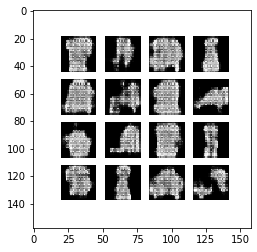

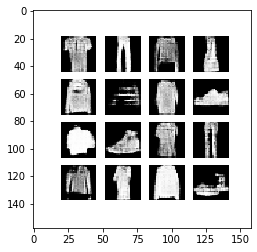

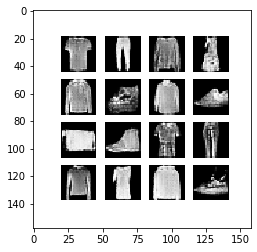

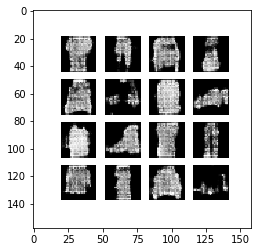

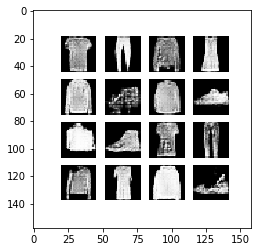

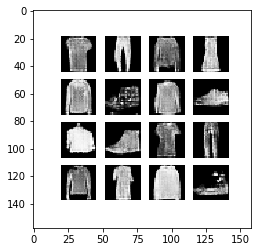

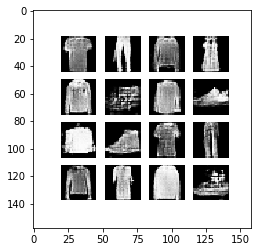

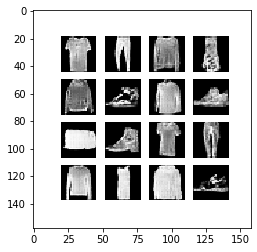

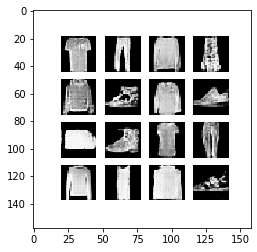

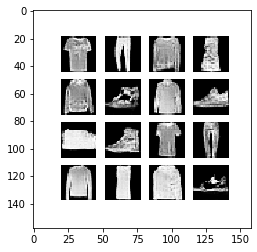

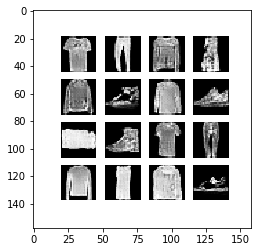

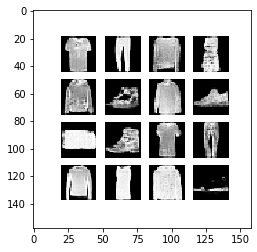

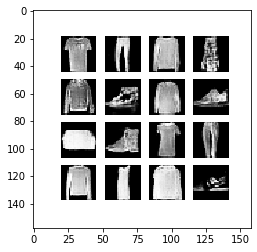

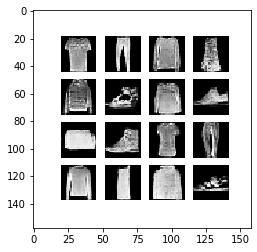

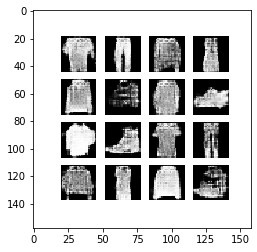

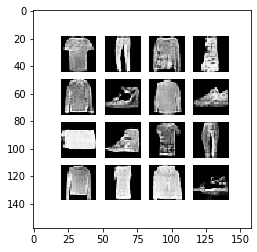

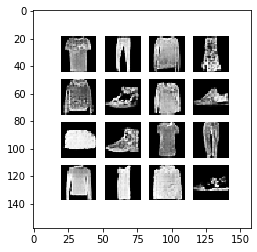

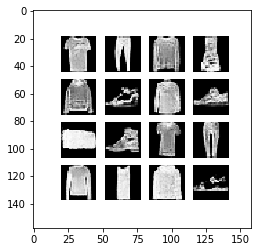

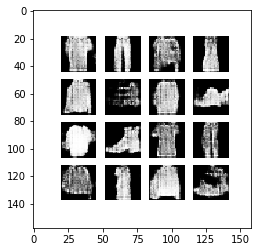

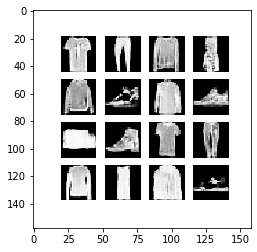

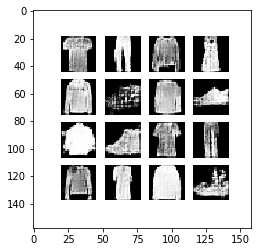

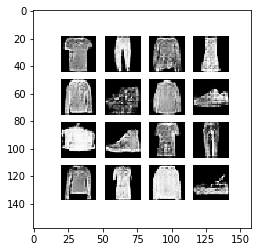

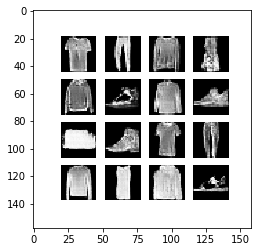

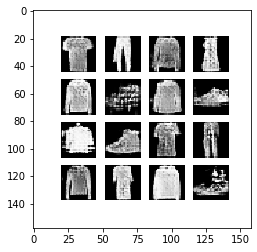

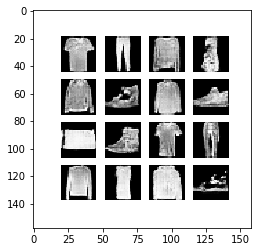

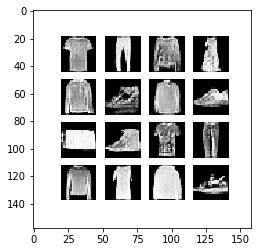

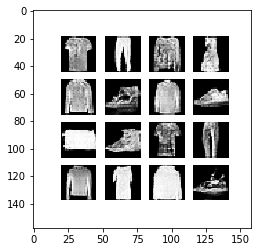

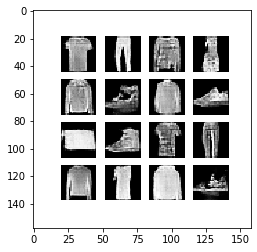

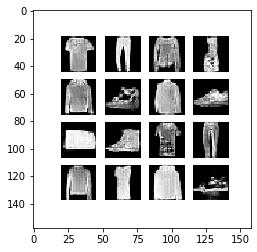

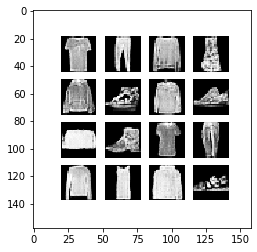

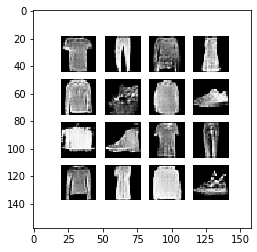

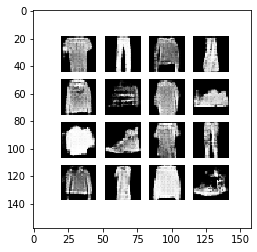

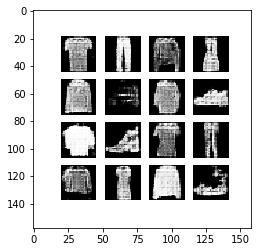

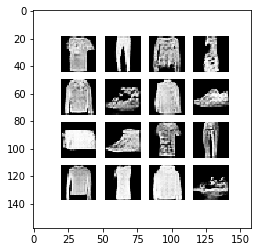

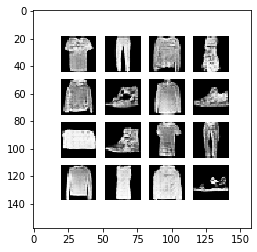

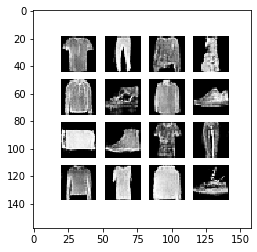

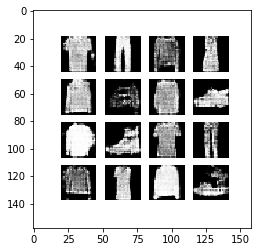

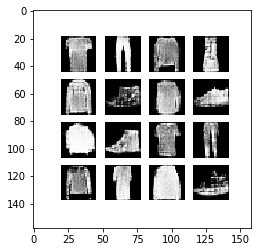

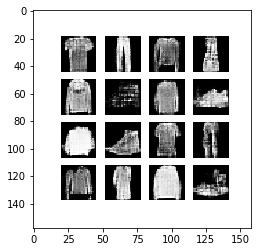

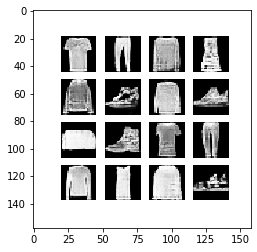

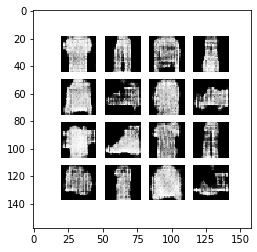

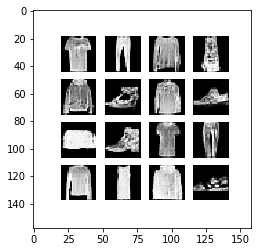

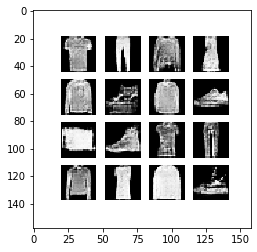

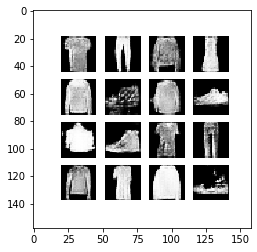

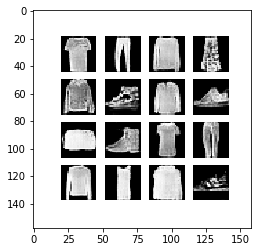

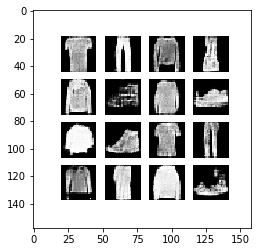

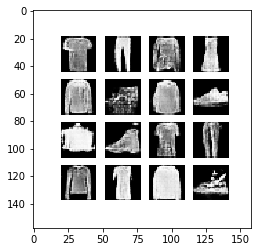

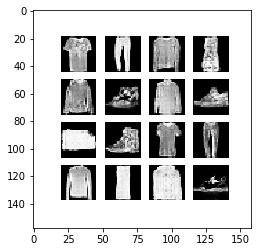

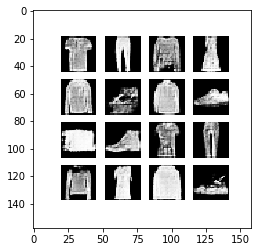

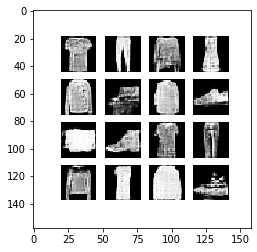

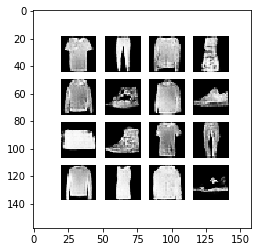

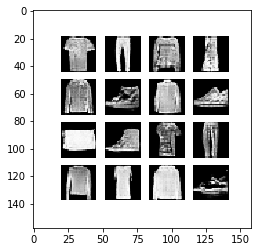

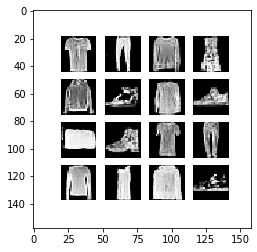

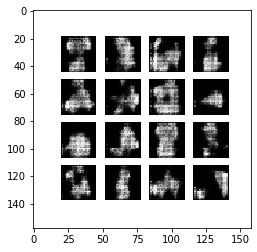

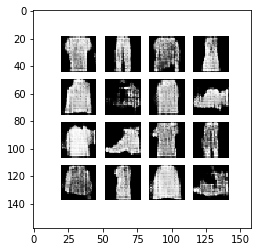

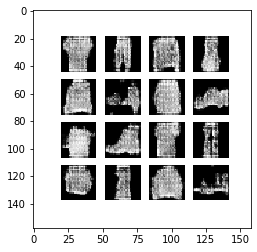

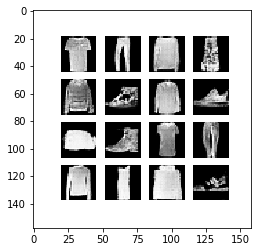

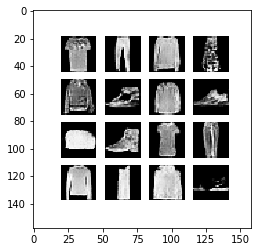

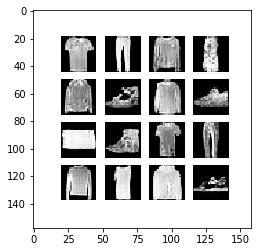

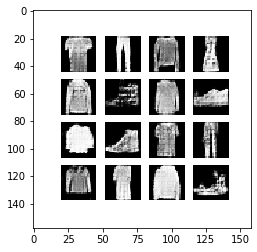

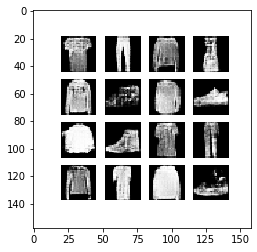

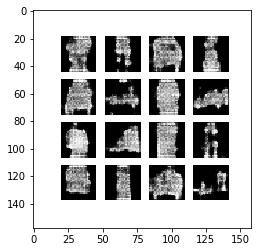

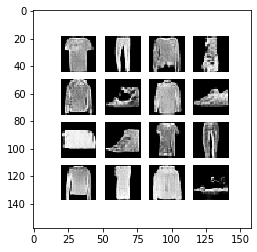

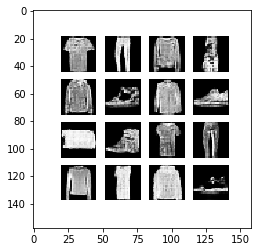

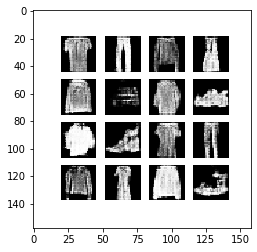

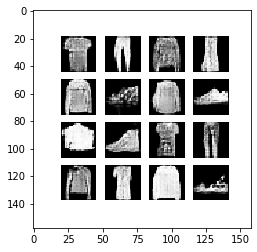

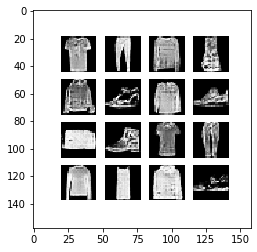

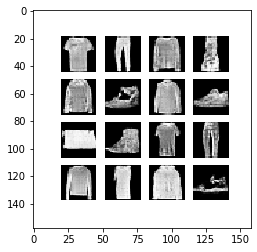

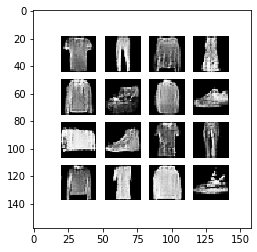

In [ ]:
for filename in glob.glob('infogan/*.png'):
    plt.figure()
    img=cv2.imread(filename)
    plt.imshow(img,cmap='binary')